In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# Two Layer GNN Metrics

For the model created in the last script, get predictions and metrics / performance information. 

Implementation notes:
  * To visualize the keras model, I had to "conda install" pydot and graphviz in my virtual environment. 
  * Model is saved/loaded in tensorflow format.  This is to workaround an issue with Keras format, https://github.com/tensorflow/tensorflow/issues/46659

*This script takes about 30 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np

In [3]:
from pathlib import Path
import importlib, pickle
from contextlib import redirect_stdout
from scikitplot.metrics import plot_lift_curve
import matplotlib.pyplot as plt

In [4]:
from stellargraph import StellarGraph
import stellargraph as sg
import keras
from stellargraph.layer import HinSAGE, MeanHinAggregator
from stellargraph.mapper import HinSAGENodeGenerator

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

import tensorflow.keras.metrics as km
from keras.utils import plot_model
from keras import initializers
import tensorflow as tf

2024-01-22 20:20:06.340611: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-01-22 20:20:06.340635: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-22 20:20:06.340644: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-22 20:20:06.340678: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-22 20:20:06.340694: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
from sba_gnn.sba_gnn import sg_gnn, sg_plot 

## Import Data

##### Stellargraphs - all nodes

In [6]:
with open(Path(setup.temp_path).joinpath('20_DATA_stellargraph_all.pkl'), 'rb') as fin:
      sba_all  = pickle.load(fin)

In [7]:
label_data = pd.read_parquet(Path(setup.temp_path).joinpath('20_DATA_label_info.parquet')).sort_index()

##### Model

In [8]:
model = keras.models.load_model(Path(setup.temp_path).joinpath('23_DATA_model.keras'),
                               safe_mode=False,
                               custom_objects={'MeanHinAggregator':MeanHinAggregator})

/Users/valeriecarey/miniconda3/envs/tf_p38/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


## Model Info
Print and save some information about the model layers (summary and plot)

In [9]:
with open(Path(setup.temp_path).joinpath('24_REPORT_model_summary.txt'), "w") as f:
    with redirect_stdout(f):
        print(model.summary())
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 20, 10)]             0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 20, 10)]             0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 200, 10)]            0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 200, 10)]            0         []                            
                                                                                              

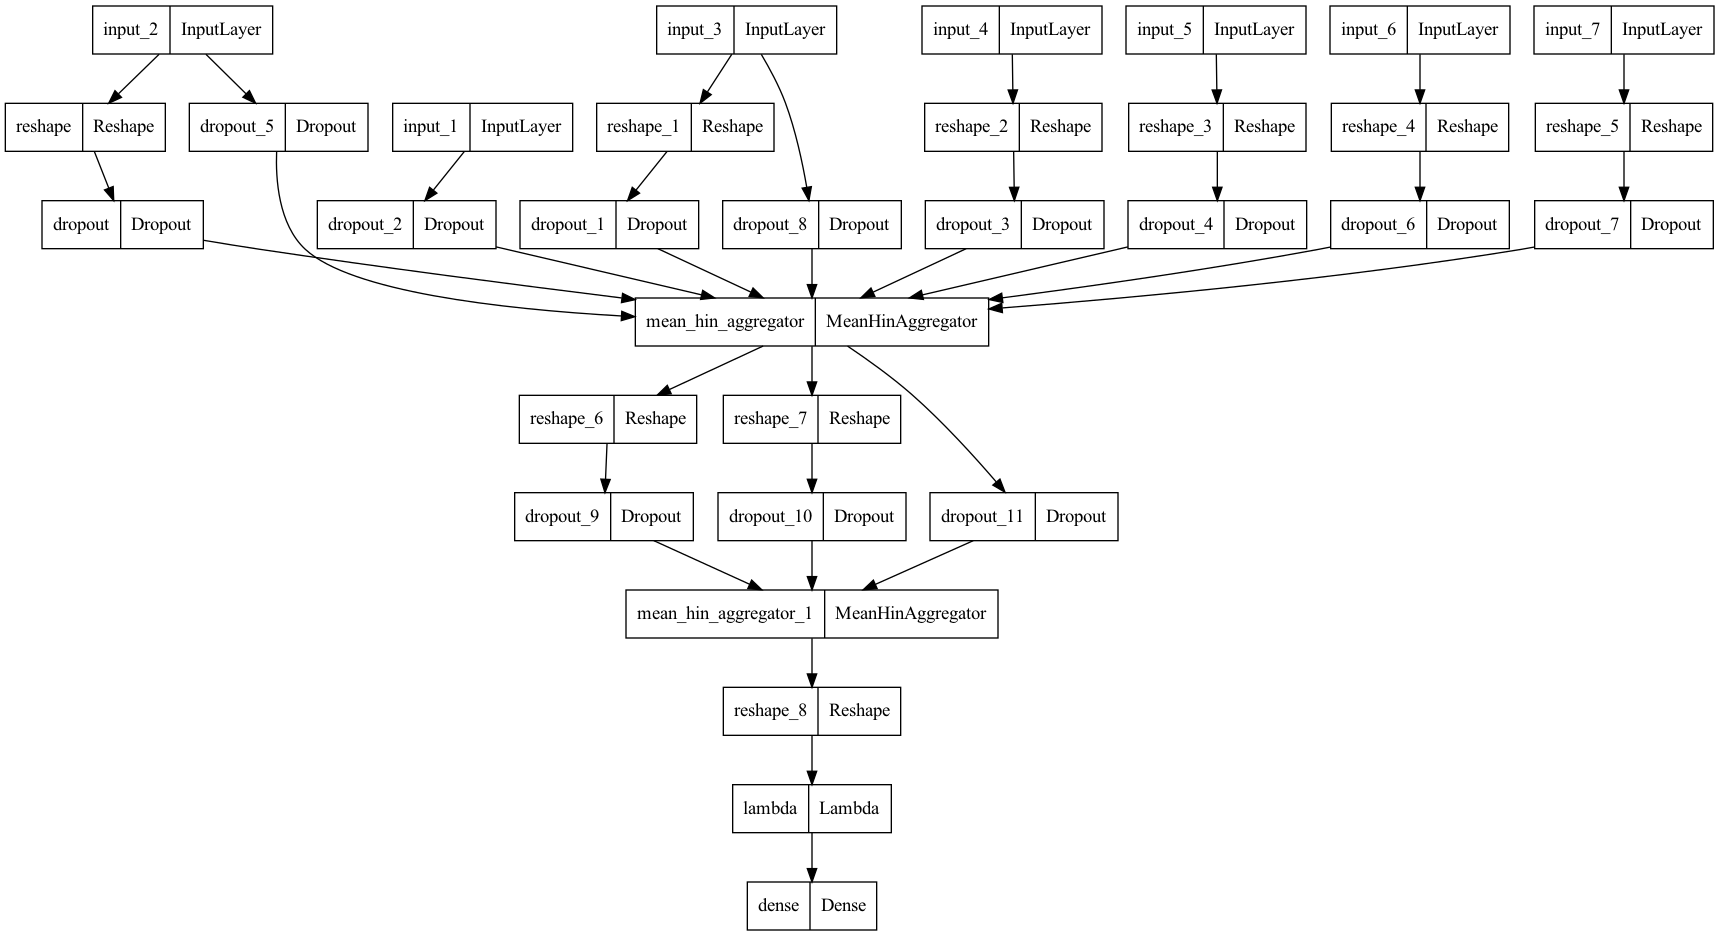

In [10]:
plot_model(model, Path(setup.temp_path).joinpath('24_model_plot_simp.png'))

The 2-hop model has three MeanHinAggregator layers, likely reflecting the 2 edge types.

In [11]:
%%capture
plot_model(model, to_file=Path(setup.temp_path).joinpath('24_model_plot_with_shapes.png'),
          show_shapes=True)

## Graph Containing All Nodes
Get predictions amd metrics

##### Get generator and predict for all nodes (train, validation, test)

In [12]:
generator = HinSAGENodeGenerator(sba_all, batch_size=setup.gnn_batch_size, 
                                 num_samples=setup.gnn_num_samples,
                                 head_node_type='LoanNr_ChkDgt',
                                 seed=2454)

In [13]:
all_flow = generator.flow(label_data.index, label_data['target'], shuffle=False)

In [14]:
tf.random.set_seed(16)
keras.utils.set_random_seed(812)
sg.random.set_seed(4345)

In [ ]:
all_predictions = model.predict(all_flow)

2024-01-22 20:22:44.088063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14986/21503 [===================>..........] - ETA: 6:02

In [ ]:
all_predictions.shape

In [ ]:
pd.Series(all_predictions[:,0], index=label_data.index)

In [ ]:
all_pred_df = pd.concat([pd.Series(all_predictions[:,0], index=label_data.index).rename('predict_prob'),
                         label_data], axis=1) \
    .reset_index()

In [ ]:
all_pred_df.head(3)

## Threshold Tune & Binary Predictions
Using training probability predictions

In [ ]:
all_pred_train = all_pred_df[all_pred_df['dset'] == 'train']

In [ ]:
thresh_tune_data = sg_plot.get_f1_frame(all_pred_train['target'], 
                                        all_pred_train['predict_prob'])

In [ ]:
thresh_tune_data.sort_values('f1', ascending=False, inplace=True)
thresh_tune_data.head(3)

In [ ]:
best_thresh = thresh_tune_data['thresh'].iloc[0]
best_thresh

##### Append binary predictions to probability predictions

In [ ]:
importlib.reload(sg_plot)

In [ ]:
all_pred_df['predict_bin'] = sg_plot.get_binary_predictions(all_pred_df['predict_prob'], best_thresh)

In [ ]:
all_pred_df['predict_bin'].value_counts(normalize=True, dropna=False)

In [ ]:
all_pred_df.to_parquet(Path(setup.temp_path).joinpath('24_DATA_predictions_all.parquet'))

In [ ]:
all_pred_df.sample(3)

In [ ]:
pd.crosstab(all_pred_df['predict_bin'], all_pred_df['target'])

## Metrics

In [ ]:
metrics_dset_df = all_pred_df.groupby('dset') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = all_pred_df[all_pred_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('24_REPORT_metrics.csv'), index=True)
metrics_df

## Lift

In [ ]:
pred_test_df = all_pred_df[all_pred_df['dset'] == 'test']

In [ ]:
plot_lift_curve(pred_test_df['target'], 
                pd.concat([1-pred_test_df['predict_prob'], pred_test_df['predict_prob']], axis=1), 
                title='Lift Curve', ax=None, figsize=(4,3), 
                title_fontsize='large', text_fontsize='medium')
plt.gca().legend(loc='upper right')
plt.gcf().savefig(Path(setup.temp_path).joinpath('24_PLOT_lift_curve.png'),bbox_inches='tight')

## Embeddings
Extract node embeddings for businesses, and save these for later analysis

In [ ]:
# Create a new model object to access the embeddings 1 layers above (normalized output)
emb_model = Model(inputs=model.input, outputs=model.layers[-2].output)

In [ ]:
embeddings = emb_model.predict(all_flow)

In [ ]:
embeddings_df = pd.DataFrame(embeddings, index=label_data.index)
embeddings_df.columns = [f'emb_{c:02d}' for c in embeddings_df.columns]

In [ ]:
embeddings_df.describe()

In [ ]:
embeddings_df.to_parquet(Path(setup.temp_path).joinpath('24_DATA_embeddings.parquet'))